# Analisi produzioe e Cosmumo di Energia
## Importare e i dati e creare la tabella

In [6]:
from scipy.optimize import minimize #libreria machine learning
import numpy as np #analisi matematiche
import pandas as pd #gestione tabelle
import wget #importare wget
df = pd.read_excel("Data.xlsx", skiprows=8, header=0)

# Assign the correct headers manually
df.columns = [
    'DateTime', 'CF_FV (%)', 'CF_FV*P_inst [kWh]', 'CF_eolico (%)',
    'CF_EO*P_inst [kWh]', 'CF_WEC (%)', 'CF_WEC*P_inst [kWh]',
    'Energia elettrica consumata sull\'isola [MWh]', 'Energia elettrica consumata sull\'isola [kWh]',
    'Produzione da generatori a diesel [kWh]', 'Difff', 'Empty1', 'Empty2', 'Empty3', 'ora',
    'FV', 'FV + EO', 'FV + EO + WEC', 'Richiesta'
]

# Drop unnecessary columns
df = df.drop(columns=['Empty1', 'Empty2', 'Empty3'])

# Convert DateTime to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Display the cleaned dataframe
df.head(200)

,DateTime,CF_FV (%),CF_FV*P_inst [kWh],CF_eolico (%),CF_EO*P_inst [kWh],CF_WEC (%),CF_WEC*P_inst [kWh],Energia elettrica consumata sull'isola [MWh],Energia elettrica consumata sull'isola [kWh],Produzione da generatori a diesel [kWh],Difff,ora,FV,FV + EO,FV + EO + WEC,Richiesta
0,2019-01-01 01:00:00,0.78,163.950820,0.18,37.513293,0.1721,28.188786,0.12,120.0,0.000000,109.652900,2019-01-01 01:00:00,163.950820,201.464113,229.652900,120.0
1,2019-01-01 02:00:00,0.72,151.339219,0.17,35.429221,0.1721,28.188786,0.14,140.0,0.000000,74.957227,2019-01-01 02:00:00,151.339219,186.768440,214.957227,140.0
2,2019-01-01 03:00:00,0.62,130.319883,0.19,39.597365,0.1721,28.188786,0.16,160.0,0.000000,38.106034,2019-01-01 03:00:00,130.319883,169.917248,198.106034,160.0
3,2019-01-01 04:00:00,0.48,100.892812,0.20,41.681437,0.1721,28.188786,0.20,200.0,29.236964,-29.236964,2019-01-01 04:00:00,100.892812,142.574249,170.763036,200.0
4,2019-01-01 05:00:00,0.27,56.752207,0.17,35.429221,0.1721,28.188786,0.23,230.0,109.629785,-109.629785,2019-01-01 05:00:00,56.752207,92.181428,120.370215,230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2019-01-09 04:00:00,0.42,88.281211,0.40,83.362874,0.2140,35.051716,0.18,180.0,0.000000,26.695801,2019-01-09 04:00:00,88.281211,171.644085,206.695801,180.0
196,2019-01-09 05:00:00,0.28,58.854141,0.33,68.774371,0.2140,35.051716,0.16,160.0,0.000000,2.680227,2019-01-09 05:00:00,58.854141,127.628512,162.680227,160.0
197,2019-01-09 06:00:00,0.09,18.917402,0.27,56.269940,0.1721,28.188786,0.21,210.0,106.623871,-106.623871,2019-01-09 06:00:00,18.917402,75.187342,103.376129,210.0
198,2019-01-09 07:00:00,0.01,2.101934,0.21,43.765509,0.1721,28.188786,0.20,200.0,125.943771,-125.943771,2019-01-09 07:00:00,2.101934,45.867442,74.056229,200.0


## Ottimiziamo la potenza installata


In [7]:
# Define the installed capacities
P_inst_FV = 50
P_inst_EO = 300
P_inst_WEC = 70

# Function to calculate the difference between produced and requested energy
def energy_difference(x, df):   #funz che voglio minimizzare
    df['CF_FV*P_opt [kWh]'] = df['CF_FV (%)'] * x[0]
    df['CF_EO*P_opt [kWh]'] = df['CF_eolico (%)'] * x[1]
    df['CF_WEC*P_opt [kWh]'] = df['CF_WEC (%)'] * x[2]
    df['Total_Produced [kWh]'] = df['CF_FV*P_opt [kWh]'] + df['CF_EO*P_opt [kWh]'] + df['CF_WEC*P_opt [kWh]']
    df['Difference'] = np.abs(df['Total_Produced [kWh]'] - df['Energia elettrica consumata sull\'isola [kWh]'])
    return np.sum(np.abs(df['Difference']))

# Initial guess for the installed capacities
x0 = [P_inst_FV, P_inst_EO, P_inst_WEC]

# Bounds for the capacities (assuming they cannot be negative and there is no upper limit specified)
bounds = [(0, None), (0, None), (0, None)]

# Optimize the capacities
result = minimize(energy_difference, x0, args=(df,), bounds=bounds)

# Extract the optimized capacities
optimized_capacities = result.x

# Calculate the mean absolute difference
mean_absolute_difference = np.mean(np.abs(df['Difference']))

# Define a formatted message with the optimization results
message = f"""
Optimization Results:
----------------------
- Optimized capacity for PV (P_inst_FV): {optimized_capacities[0]:.2f} kWh
- Optimized capacity for EO (P_inst_EO): {optimized_capacities[1]:.2f} kWh
- Optimized capacity for WEC (P_inst_WEC): {optimized_capacities[2]:.2f} kWh

- Minimized absolute difference between produced and requested energy: {result.fun:.2f} kWh
- Mean absolute difference between produced and requested energy: {mean_absolute_difference:.2f} kWh
"""

print(message)




Optimization Results:
----------------------
- Optimized capacity for PV (P_inst_FV): 41.30 kWh
- Optimized capacity for EO (P_inst_EO): 0.00 kWh
- Optimized capacity for WEC (P_inst_WEC): 569.69 kWh

- Minimized absolute difference between produced and requested energy: 748619.49 kWh
- Mean absolute difference between produced and requested energy: 85.47 kWh


##Grafici Vari

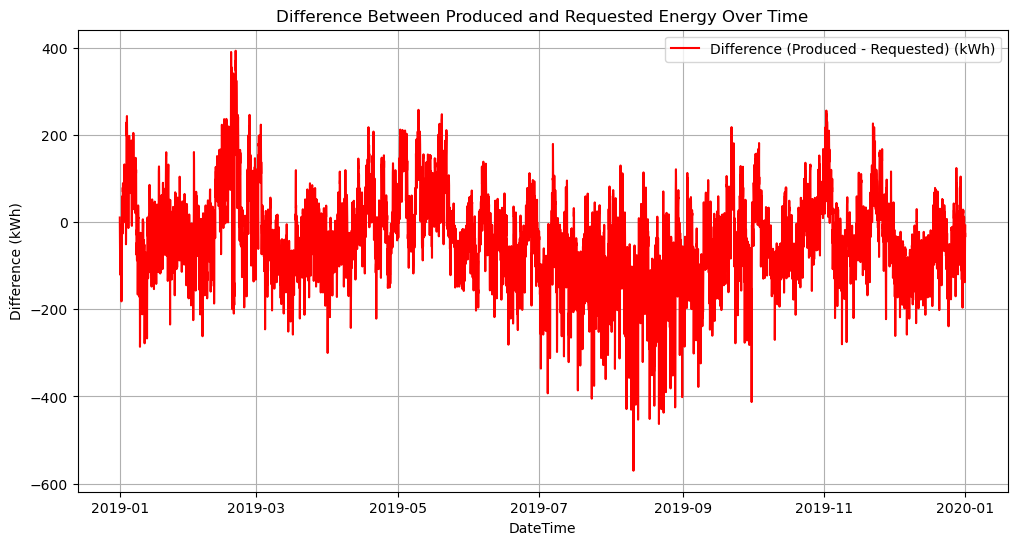

In [8]:
optimized_capacities = result.x
# Calculate the minimized difference
minimized_difference = result.fun

# Create a new DataFrame with the optimized capacities
df['CF_FV*P_opt [kWh]'] = df['CF_FV (%)'] * optimized_capacities[0]
df['CF_EO*P_opt [kWh]'] = df['CF_eolico (%)'] * optimized_capacities[1]
df['CF_WEC*P_opt [kWh]'] = df['CF_WEC (%)'] * optimized_capacities[2]
df['Total_Produced [kWh]'] = df['CF_FV*P_opt [kWh]'] + df['CF_EO*P_opt [kWh]'] + df['CF_WEC*P_opt [kWh]']
df['Difference'] = df['Total_Produced [kWh]'] - df['Energia elettrica consumata sull\'isola [kWh]']

# Prepare the data for plotting
df['Year'] = df['DateTime'].dt.year
numeric_columns = ['Total_Produced [kWh]', 'Energia elettrica consumata sull\'isola [kWh]']
annual_data = df.groupby('Year')[numeric_columns].sum()

# Plot the annual variation in produced and requested energy

# Plot the difference between produced and requested energy
plt.figure(figsize=(12, 6))
plt.plot(df['DateTime'], df['Difference'], label='Difference (Produced - Requested) (kWh)', color='red')
plt.xlabel('DateTime')
plt.ylabel('Difference (kWh)')
plt.title('Difference Between Produced and Requested Energy Over Time')
plt.legend()
plt.grid(True)
plt.show()



## Grafico con media mobile a Giornaliera

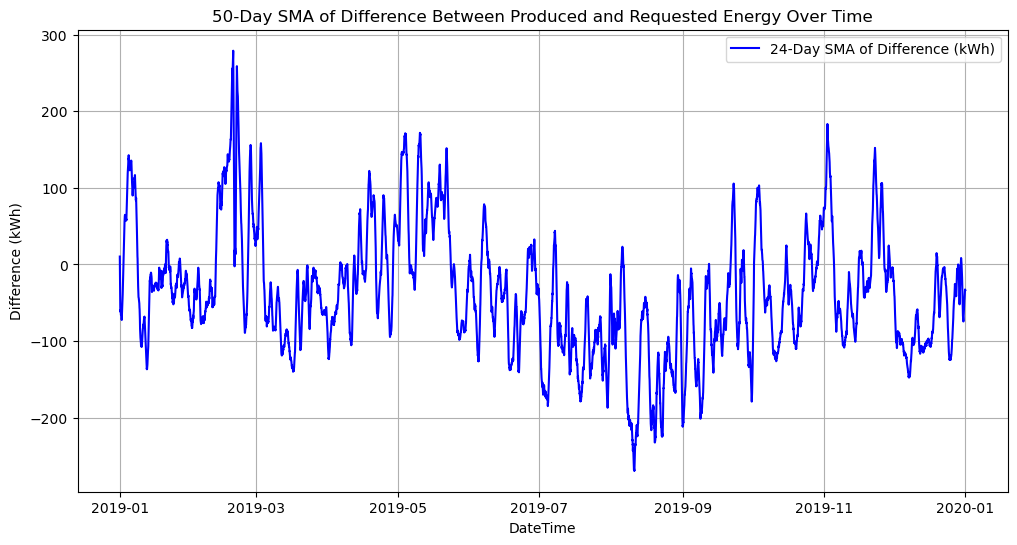

In [9]:
df['Difference_SMA_50'] = df['Difference'].rolling(window=24, min_periods=1).mean()

# Plot the 50-day SMA of the difference between produced and requested energy
plt.figure(figsize=(12, 6))
plt.plot(df['DateTime'], df['Difference_SMA_50'], label='24-Day SMA of Difference (kWh)', color='blue')
plt.xlabel('DateTime')
plt.ylabel('Difference (kWh)')
plt.title('50-Day SMA of Difference Between Produced and Requested Energy Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Proviamo ad usare un altro ottimizzatore

In [10]:
from scipy.optimize import differential_evolution

# Funzione per calcolare la differenza assoluta tra energia prodotta e richiesta
def energy_difference(x, df):   #funzione che vogliamo minimizzare
    df['CF_FV*P_opt [kWh]'] = df['CF_FV (%)'] * x[0]
    df['CF_EO*P_opt [kWh]'] = df['CF_eolico (%)'] * x[1]
    df['CF_WEC*P_opt [kWh]'] = df['CF_WEC (%)'] * x[2]
    df['Total_Produced [kWh]'] = df['CF_FV*P_opt [kWh]'] + df['CF_EO*P_opt [kWh]'] + df['CF_WEC*P_opt [kWh]']
    df['Difference'] = df['Total_Produced [kWh]'] - df['Energia elettrica consumata sull\'isola [kWh]']
    return np.sum(np.abs(df['Difference']))

# Limiti per le capacità (assumendo che non possano essere negative e fissando un limite superiore di 1000 kWh)
bounds = [(0, 1000), (0, 1000), (0, 1000)]

# Ottimizzare le capacità usando il metodo "Differential Evolution"
result_de = differential_evolution(energy_difference, bounds, args=(df,))

# Estrarre le capacità ottimizzate
optimized_capacities_de = result_de.x

# Calcolare la differenza assoluta media
mean_absolute_difference_de = np.mean(np.abs(df['Difference']))

# Definire un messaggio formattato con i risultati dell'ottimizzazione
message_de = f"""
Risultati dell'Ottimizzazione:
------------------------------
- Capacità ottimizzata per FV (P_inst_FV): {optimized_capacities_de[0]:.2f} kWh
- Capacità ottimizzata per EO (P_inst_EO): {optimized_capacities_de[1]:.2f} kWh
- Capacità ottimizzata per WEC (P_inst_WEC): {optimized_capacities_de[2]:.2f} kWh

- Differenza assoluta minima tra energia prodotta e richiesta: {result_de.fun:.2f} kWh
- Differenza assoluta media tra energia prodotta e richiesta: {mean_absolute_difference_de:.2f} kWh
"""

print(message_de)



Risultati dell'Ottimizzazione:
------------------------------
- Capacità ottimizzata per FV (P_inst_FV): 41.24 kWh
- Capacità ottimizzata per EO (P_inst_EO): 0.00 kWh
- Capacità ottimizzata per WEC (P_inst_WEC): 569.88 kWh

- Differenza assoluta minima tra energia prodotta e richiesta: 748619.49 kWh
- Differenza assoluta media tra energia prodotta e richiesta: 85.47 kWh


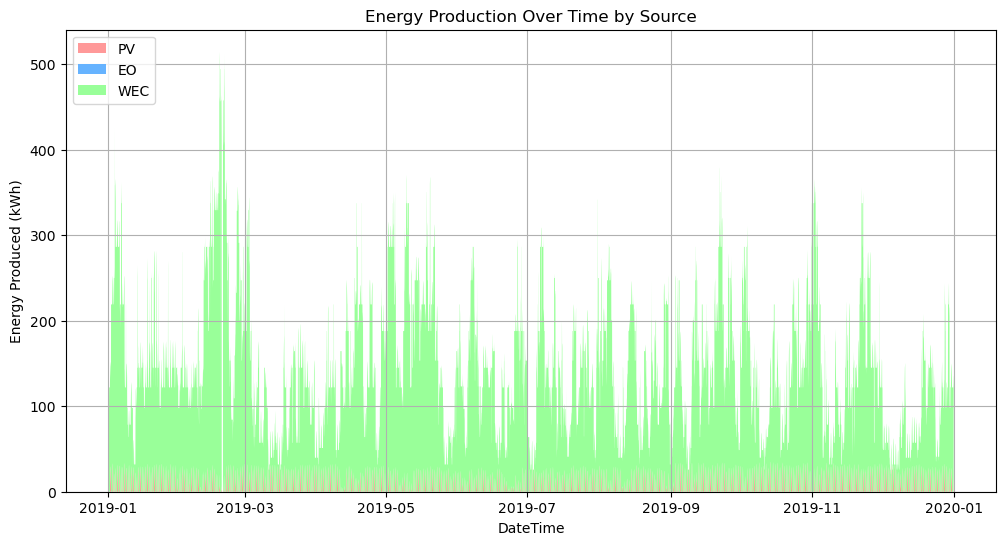

In [11]:
df['Energy_Produced_FV'] = df['CF_FV (%)'] * optimized_capacities[0]
df['Energy_Produced_EO'] = df['CF_eolico (%)'] * optimized_capacities[1]
df['Energy_Produced_WEC'] = df['CF_WEC (%)'] * optimized_capacities[2]

# Create a stacked area plot
plt.figure(figsize=(12, 6))
plt.stackplot(df['DateTime'], df['Energy_Produced_FV'], df['Energy_Produced_EO'], df['Energy_Produced_WEC'], labels=['PV', 'EO', 'WEC'], colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.xlabel('DateTime')
plt.ylabel('Energy Produced (kWh)')
plt.title('Energy Production Over Time by Source')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


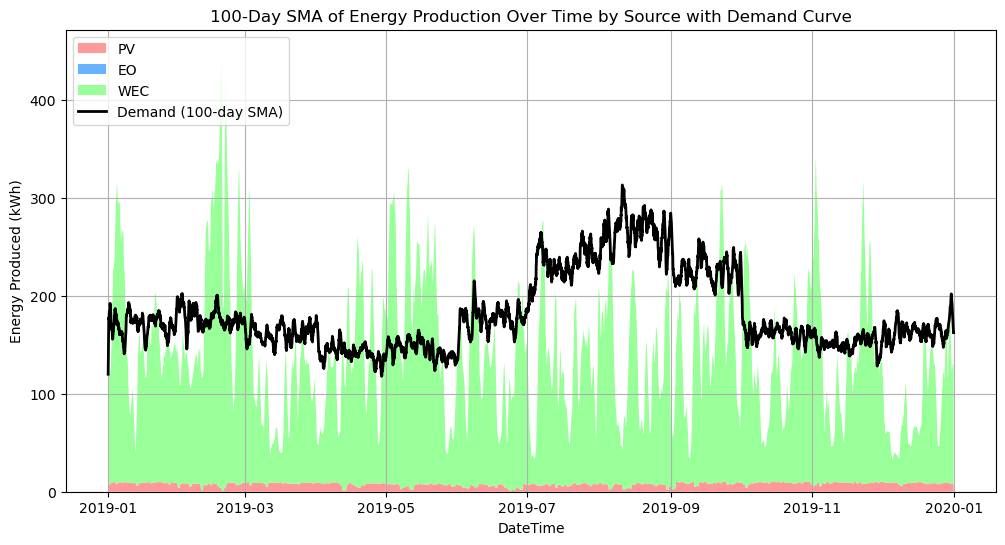

In [12]:
# Calculate the 100-day Simple Moving Average (SMA) for each energy source and demand
df['SMA_100_FV'] = df['Energy_Produced_FV'].rolling(window=24, min_periods=1).mean()
df['SMA_100_EO'] = df['Energy_Produced_EO'].rolling(window=24, min_periods=1).mean()
df['SMA_100_WEC'] = df['Energy_Produced_WEC'].rolling(window=24, min_periods=1).mean()
df['SMA_100_Demand'] = df['Energia elettrica consumata sull\'isola [kWh]'].rolling(window=24, min_periods=1).mean()

# Create a stacked area plot with 100-day SMA and demand curve
plt.figure(figsize=(12, 6))
plt.stackplot(df['DateTime'], df['SMA_100_FV'], df['SMA_100_EO'], df['SMA_100_WEC'], labels=['PV', 'EO', 'WEC'], colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.plot(df['DateTime'], df['SMA_100_Demand'], label='Demand (100-day SMA)', color='black', linewidth=2)
plt.xlabel('DateTime')
plt.ylabel('Energy Produced (kWh)')
plt.title('100-Day SMA of Energy Production Over Time by Source with Demand Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


# Adesso identifichiamo la  capacita'

In [13]:
# Calculate the difference between produced and requested energy
df['Difference'] = df['Total_Produced [kWh]'] - df['Energia elettrica consumata sull\'isola [kWh]']

# Calculate the cumulative difference
df['Cumulative_Difference'] = df['Difference'].cumsum()

# Identify the maximum cumulative deficit (i.e., the most negative value in the cumulative difference)
max_cumulative_deficit = df['Cumulative_Difference'].min()

# The required battery capacity to cover all deficits
required_battery_capacity = abs(max_cumulative_deficit)

print(f" Capacita richiesta per minimizzare la differenza {round(required_battery_capacity,2)} Kwh")

 Capacita richiesta per minimizzare la differenza 329395.41 Kwh


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Supponendo che il dataframe df_cleaned sia già pulito e contenga i dati necessari

def energy_balance_multi_objective(x, df, weights):
    P_FV, P_EO, P_WEC, Battery_Capacity = x

    # Calcolare l'energia prodotta da ogni fonte
    energy_produced_fv = df['CF_FV (%)'].values * P_FV
    energy_produced_eo = df['CF_eolico (%)'].values * P_EO
    energy_produced_wec = df['CF_WEC (%)'].values * P_WEC

    # Calcolare l'energia totale prodotta
    total_produced = energy_produced_fv + energy_produced_eo + energy_produced_wec

    # Calcolare la differenza tra energia prodotta e richiesta
    energy_consumed = df['Energia elettrica consumata sull\'isola [kWh]'].values
    difference = total_produced - energy_consumed

    # Inizializzare lo stato della batteria e il net difference
    battery_level = np.zeros(len(difference))
    battery_output = np.zeros(len(difference))
    net_difference = np.zeros(len(difference))

    for i in range(1, len(difference)):
        if difference[i] > 0: #se la differenza e' positiva carica la batteria
            new_battery_level = battery_level[i-1] + difference[i]
            if new_battery_level > Battery_Capacity: #se la batteria e' quasi piena il resto viene buttato :(
                net_difference[i] = new_battery_level - Battery_Capacity #energia sprecata da sovraccarico
                battery_level[i] = Battery_Capacity
            else:
                battery_level[i] = new_battery_level #altrimenti viene immagazzinato
                net_difference[i] = 0 #energia immagazzinata totalmente
        else: #se la differenza e' negativa
            new_battery_level = battery_level[i-1] + difference[i]
            if new_battery_level >= 0:   #e la batteria ha abbastanza carica per colmarla
                battery_level[i] = new_battery_level #la batteria si scarica di quella quantita
                net_difference[i] = 0 #e la differenza e' zero
            else:
                net_difference[i] = difference[i] + battery_level[i-1] #altrimenti cerca di aiutare quanto puo
                battery_level[i] = 0 #pero si scarica :(
        battery_output[i] = battery_level[i-1] - battery_level[i] #Input / Output Batteria

    total_net_difference = np.sum(np.abs(net_difference))
    mean_net_difference = np.mean(np.abs(net_difference))
    abs_net_difference = np.sum(np.abs(net_difference))

    if np.isnan(total_net_difference) or np.isinf(total_net_difference):
        print(f"Found nan or inf in total_net_difference. x: {x}")
        return np.inf, mean_net_difference, abs_net_difference, battery_output, battery_level

    # Calcolare la funzione obiettivo combinata
    objective_value = total_net_difference * weights[0] +  Battery_Capacity * weights[1] + np.sum(energy_produced_fv) * weights[2] + np.sum(energy_produced_eo) * weights[3] + np.sum(energy_produced_wec)*weights[4]

    return objective_value, mean_net_difference, abs_net_difference, battery_output, battery_level

# Definire i pesi per gli obiettivi
weight_diff = 1 #importanza nel minimizzare la differenza di energia
weight_battery = 1 #importanza nel mantenere contenuta la grandezza della batteria
weight_FV = 0.001  #Valori negativi incentivano il fotovoltaico , Numeri positivi lo disincentivano
weight_EO = 0 #Valori negativi incentivano il Eolico , Numeri lo disincentivano
weight_WEC = 0.005 #Valori negativi incentivano il Marino, Numeri positivi lo disincentivano
bounds = [(0, 1000), (0, 1000), (0, 1000), (0, 5000000)]
weights = [weight_diff, weight_battery, weight_FV, weight_EO, weight_WEC]

# Pulizia dei dati
df_cleaned = df.copy()
df_cleaned.fillna(0, inplace=True)
df_cleaned.replace([np.inf, -np.inf], 0, inplace=True)

# Funzione lambda per ottenere solo il valore della funzione obiettivo
result = differential_evolution(lambda x: energy_balance_multi_objective(x, df_cleaned, weights)[0], bounds, maxiter=100, popsize=20)
optimized_capacities = result.x

# Calcolare nuovamente la differenza media, assoluta e la carica della batteria per la soluzione ottimizzata
objective_value, mean_net_difference, abs_net_difference, battery_output, battery_level = energy_balance_multi_objective(optimized_capacities, df_cleaned, weights)

message = f"""
Risultati dell'Ottimizzazione Multi-Obiettivo:
-------------------------------------------
- Capacità ottimizzata per FV (P_inst_FV): {optimized_capacities[0]:.2f} kWh
- Capacità ottimizzata per EO (P_inst_EO): {optimized_capacities[1]:.2f} kWh
- Capacità ottimizzata per WEC (P_inst_WEC): {optimized_capacities[2]:.2f} kWh
- Capacità ottimizzata per la Batteria: {optimized_capacities[3]:.2f} kWh

- Valore della funzione obiettivo combinata: {objective_value:.2f}
- Differenza assoluta totale tra energia prodotta e richiesta: {abs_net_difference:.2f} kWh
- Differenza media tra energia prodotta e richiesta: {mean_net_difference:.2f} kWh
"""

print(message)

# Aggiungere l'output della batteria al dataframe
df_cleaned['Battery_Output'] = battery_output


C:\Users\dadoi\AppData\Local\Temp\ipykernel_13976\2904519813.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_cleaned.fillna(0, inplace=True)



Risultati dell'Ottimizzazione Multi-Obiettivo:
-------------------------------------------
- Capacità ottimizzata per FV (P_inst_FV): 636.75 kWh
- Capacità ottimizzata per EO (P_inst_EO): 136.89 kWh
- Capacità ottimizzata per WEC (P_inst_WEC): 17.86 kWh
- Capacità ottimizzata per la Batteria: 150614.15 kWh

- Valore della funzione obiettivo combinata: 154592.11
- Differenza assoluta totale tra energia prodotta e richiesta: 2748.39 kWh
- Differenza media tra energia prodotta e richiesta: 0.31 kWh


###Con le batterie usiamo anche l'eolico e la differenza diventa 0 !

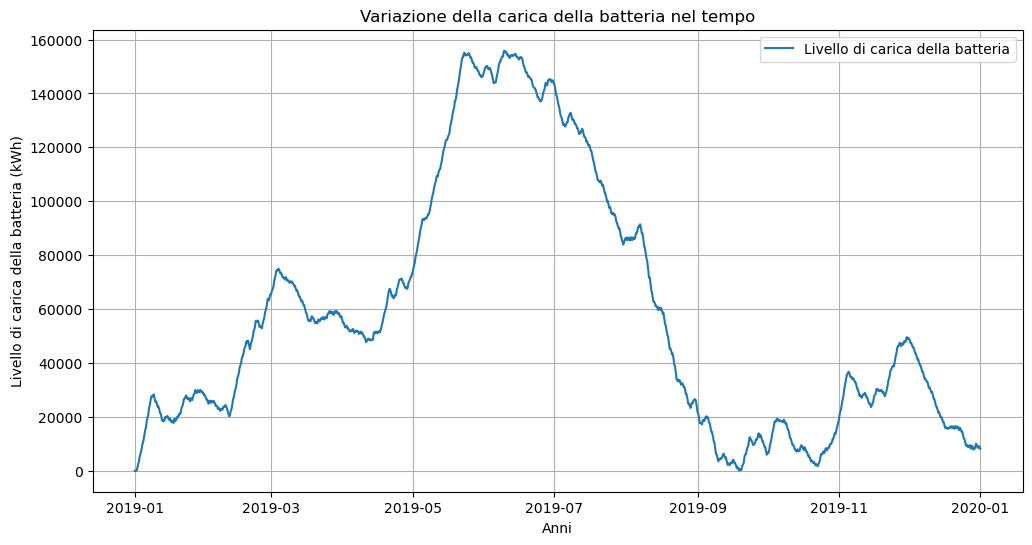

In [15]:
# Creare il grafico della carica della batteria
plt.figure(figsize=(12, 6))
plt.plot(df['DateTime'],battery_level, label='Livello di carica della batteria')
plt.xlabel('Anni')
plt.ylabel('Livello di carica della batteria (kWh)')
plt.title('Variazione della carica della batteria nel tempo')
plt.legend()
plt.grid(True)
plt.show()

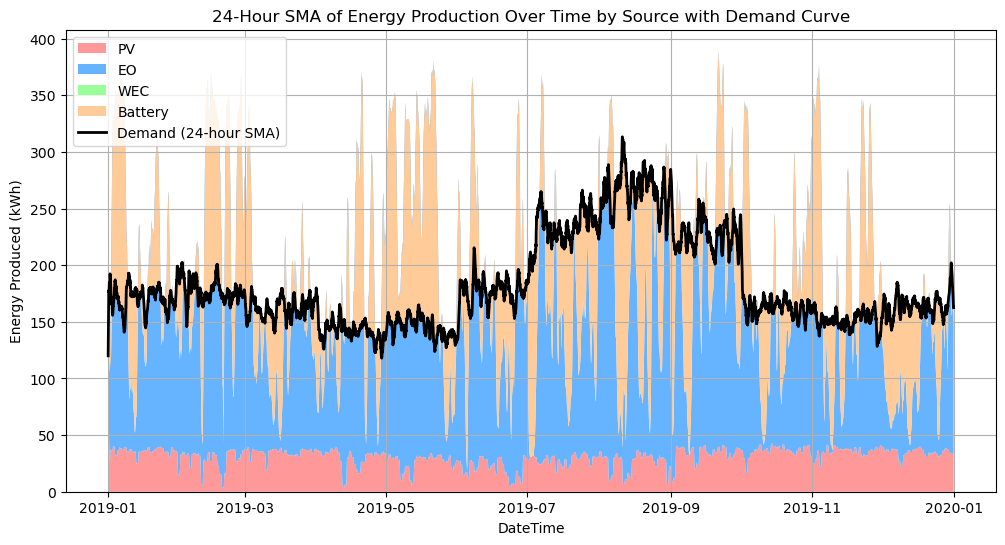

In [16]:
# Calcolare l'energia prodotta da ciascuna fonte con le capacità ottimizzate
df_cleaned['Energy_Produced_FV'] = df_cleaned['CF_FV (%)'] * optimized_capacities[0]
df_cleaned['Energy_Produced_EO'] = df_cleaned['CF_eolico (%)'] * optimized_capacities[1]
df_cleaned['Energy_Produced_WEC'] = df_cleaned['CF_WEC (%)'] * optimized_capacities[2]

# Calcolare la media mobile a 24 ore per ciascuna fonte e la domanda
df_cleaned['SMA_100_FV'] = df_cleaned['Energy_Produced_FV'].rolling(window=24, min_periods=1).mean()
df_cleaned['SMA_100_EO'] = df_cleaned['Energy_Produced_EO'].rolling(window=24, min_periods=1).mean()
df_cleaned['SMA_100_WEC'] = df_cleaned['Energy_Produced_WEC'].rolling(window=24, min_periods=1).mean()
df_cleaned['SMA_100_Demand'] = df_cleaned['Energia elettrica consumata sull\'isola [kWh]'].rolling(window=24, min_periods=1).mean()
df_cleaned['SMA_100_Battery'] = df_cleaned['Battery_Output'].rolling(window=24, min_periods=1).mean()
#df_cleaned['SMA_100_Battery'] = [0 if x < 0 else x for x in df_cleaned['SMA_100_Battery']]
# Creare un grafico ad area impilata con la SMA a 24 ore e la curva della domanda
plt.figure(figsize=(12, 6))
plt.stackplot(df['DateTime'], df_cleaned['SMA_100_FV'], df_cleaned['SMA_100_EO'], df_cleaned['SMA_100_WEC'], df_cleaned['SMA_100_Battery'],
              labels=['PV', 'EO', 'WEC', 'Battery'], colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.plot(df['DateTime'], df_cleaned['SMA_100_Demand'], label='Demand (24-hour SMA)', color='black', linewidth=2)



plt.xlabel('DateTime')
plt.ylabel('Energy Produced (kWh)')
plt.title('24-Hour SMA of Energy Production Over Time by Source with Demand Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Batteria:

*  La batteria sopra la domanda: La Batteria si carica
*  La batteria sotto la domanda: La Batteria si scarica



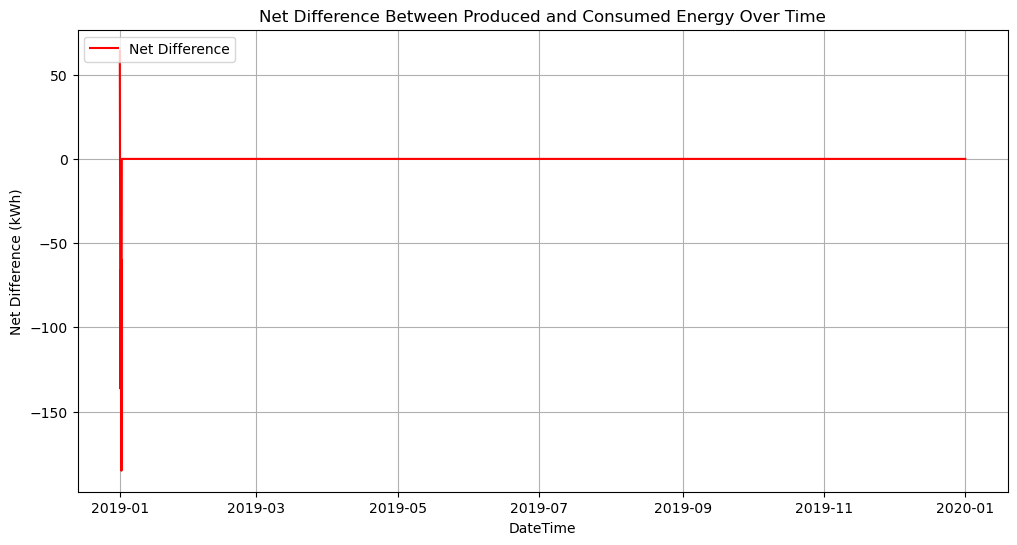

In [17]:


# Calcolare la differenza tra l'energia prodotta e la domanda
df_cleaned['Net_Difference'] = df_cleaned['Energy_Produced_FV'] + df_cleaned['Energy_Produced_EO'] + df_cleaned['Energy_Produced_WEC'] + df_cleaned['Battery_Output'] - df_cleaned['Energia elettrica consumata sull\'isola [kWh]']

# Creare un grafico della differenza tra l'energia prodotta e la domanda
plt.figure(figsize=(12, 6))
plt.plot(df['DateTime'], df_cleaned['Net_Difference'], label='Net Difference', color='red')
plt.xlabel('DateTime')
plt.ylabel('Net Difference (kWh)')
plt.title('Net Difference Between Produced and Consumed Energy Over Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
